# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "16.00.01"   
TFlite_MainType = "ana-cont"
TFlite_Size     = "s0"
Training_Percentage = 0.05              # 0.0 = Use all Images for Training

##########################################################################

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

from augmentation import augmentation, no_augmentation
from plot_functions import plot_dataset, plot_dataset_analog

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    x_train = x_data
    y_train = y_data

(909, 32, 32, 3)
(909, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64,activation="relu")(x)
output = tf.keras.layers.Dense(2)(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,350 (556.05 KB)

 Trainable params: 140,872 (550.28 KB)

 Non-trainable params: 1,478 (5.77 KB)

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

Train data


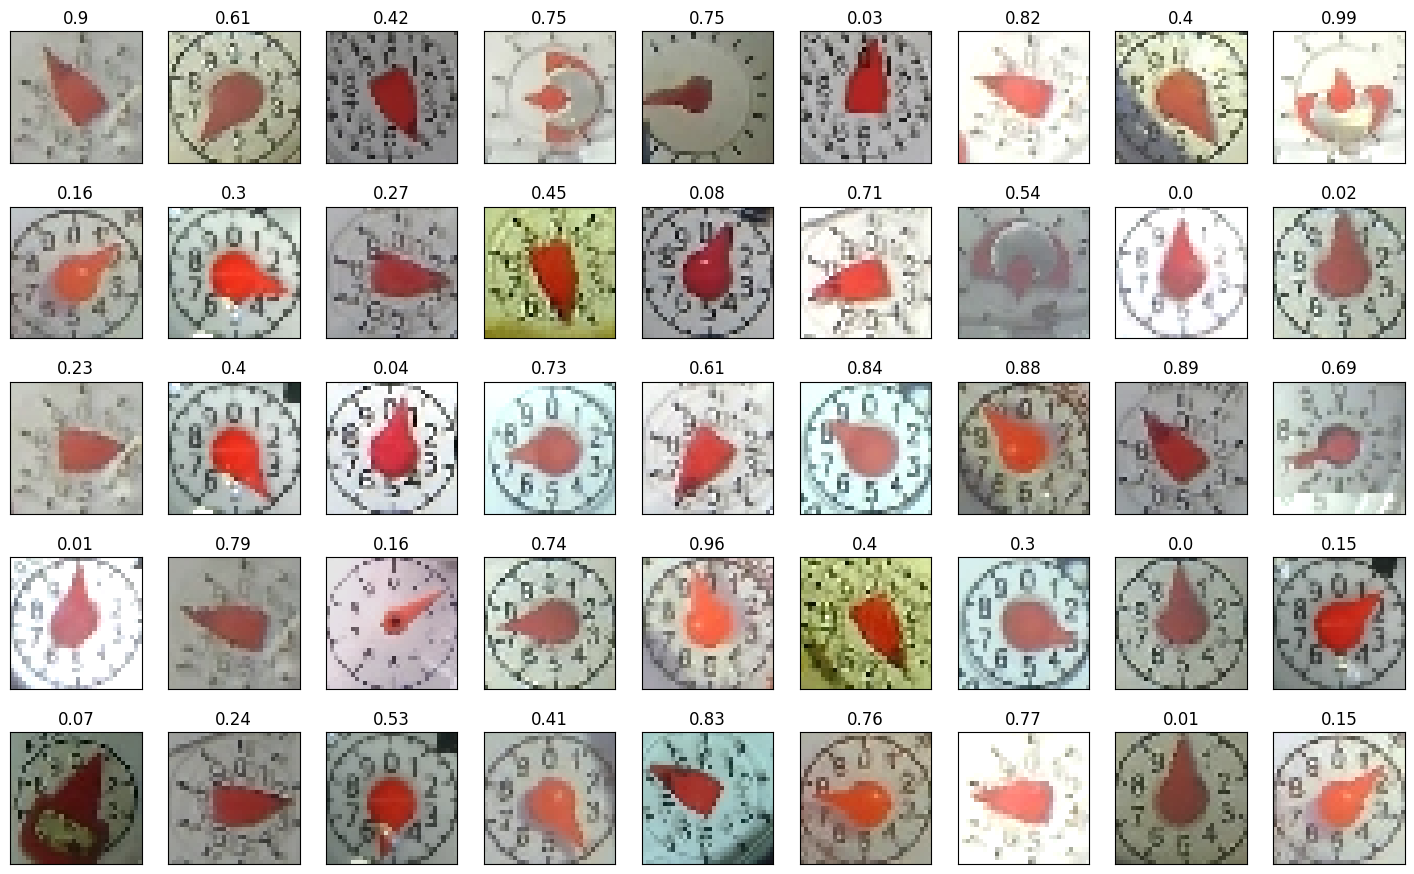

  
  
Validation data


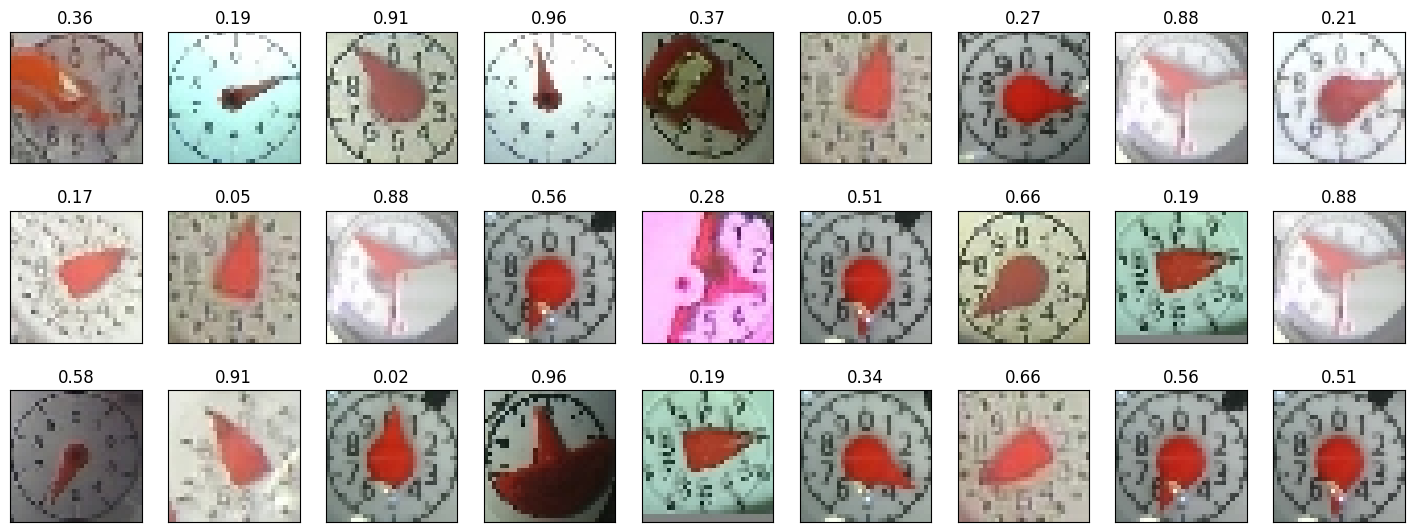

In [4]:
Batch_Size = 8
Shift_Range = 0
Brightness_Range = 0.3

# train data
print("Train data")
#train_iterator = augmentation(x_data, y_data)
train_iterator = augmentation(x_train, y_train,
                             _Batch_Size          = Batch_Size, 
                             _width_shift_range   = 0, 
                             _height_shift_range  = 0,
                             _brightness_range    = [1-Brightness_Range, 1+Brightness_Range],
                             _zoom_range_In       = 0,
                             _zoom_range_Out      = 0,
                             _rotation_range      = 0,
                             _channel_shift_range = 0,
                             _shear_range         = 0,
                             _preprocessing       = False)
plot_dataset_analog(train_iterator)     

if (Training_Percentage > 0):
    # validation data
    validation_iterator = no_augmentation(x_test, y_test)
    print("  ")
    print("  ")
    print("Validation data")
    plot_dataset_analog(validation_iterator, rows=3) 


### Step 1: Brigthness scattering only

In [5]:
Epoch_Anz = 30

if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)


Epoch 1/30


C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5503 - loss: 1.0224 - val_accuracy: 0.6304 - val_loss: 0.5132
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6204 - loss: 0.5785 - val_accuracy: 0.7826 - val_loss: 0.3398
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6784 - loss: 0.5028 - val_accuracy: 0.6739 - val_loss: 0.5486
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6606 - loss: 0.4598 - val_accuracy: 0.7174 - val_loss: 0.6157
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7730 - loss: 0.4082 - val_accuracy: 0.8478 - val_loss: 0.2179
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7506 - loss: 0.3243 - val_accuracy: 0.8261 - val_loss: 0.6238
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7698 - loss: 0.3027 - val_accuracy: 0.7826 - val_loss: 0.2147
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7990 - loss: 0.2460 - val_accuracy: 0.8478 - val

### Step 1: Learing result
 
* Visualization of the training and validation results

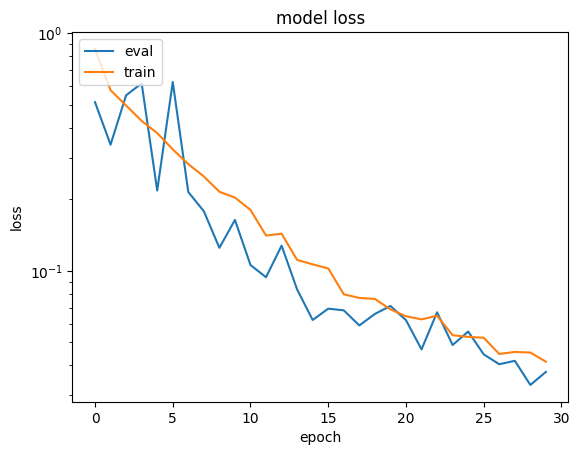

In [6]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['eval','train'], loc='upper left')
plt.show()

Train data


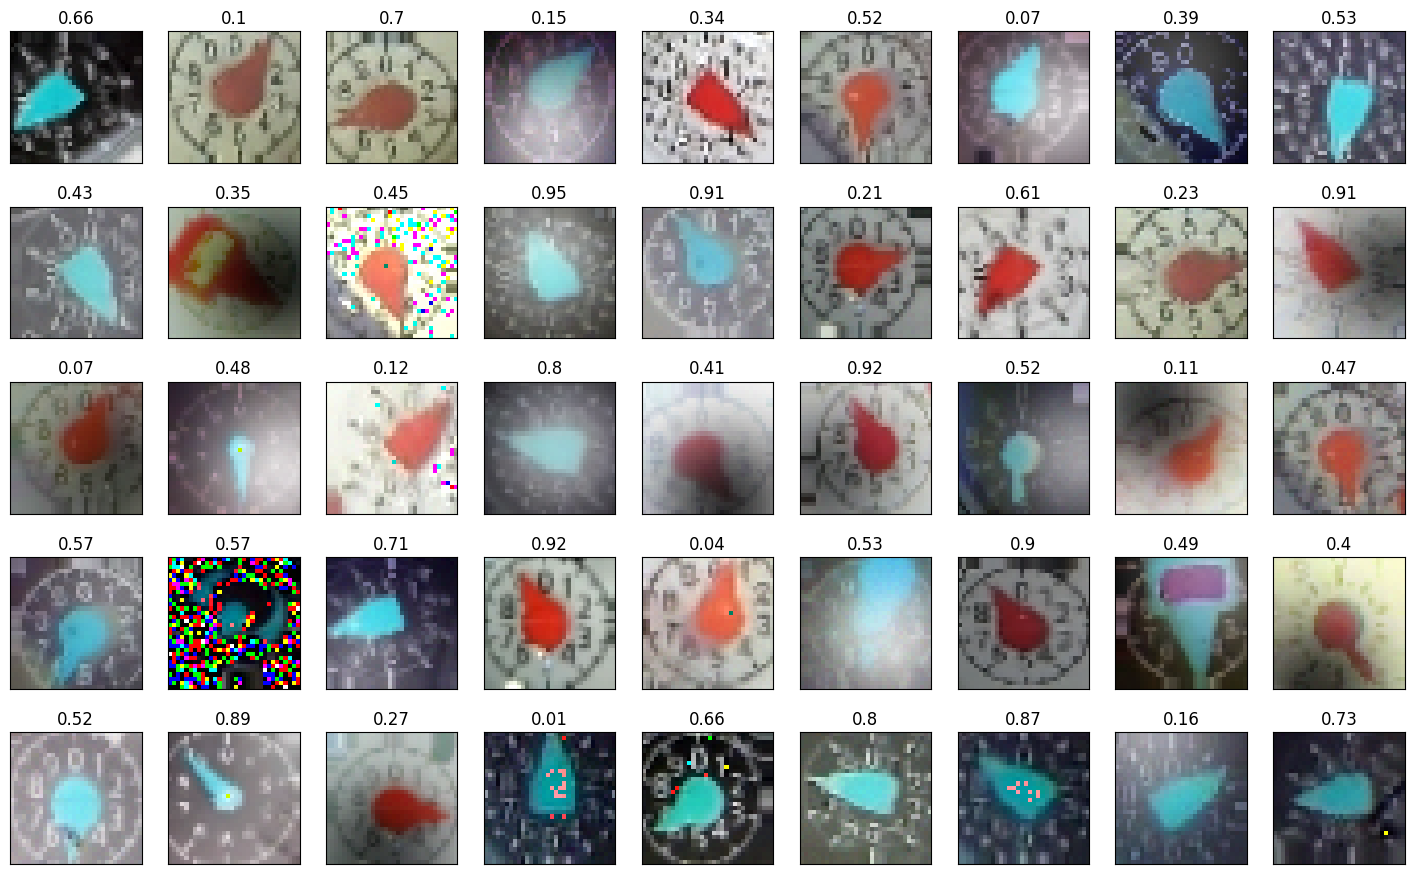

  
  
Validation data


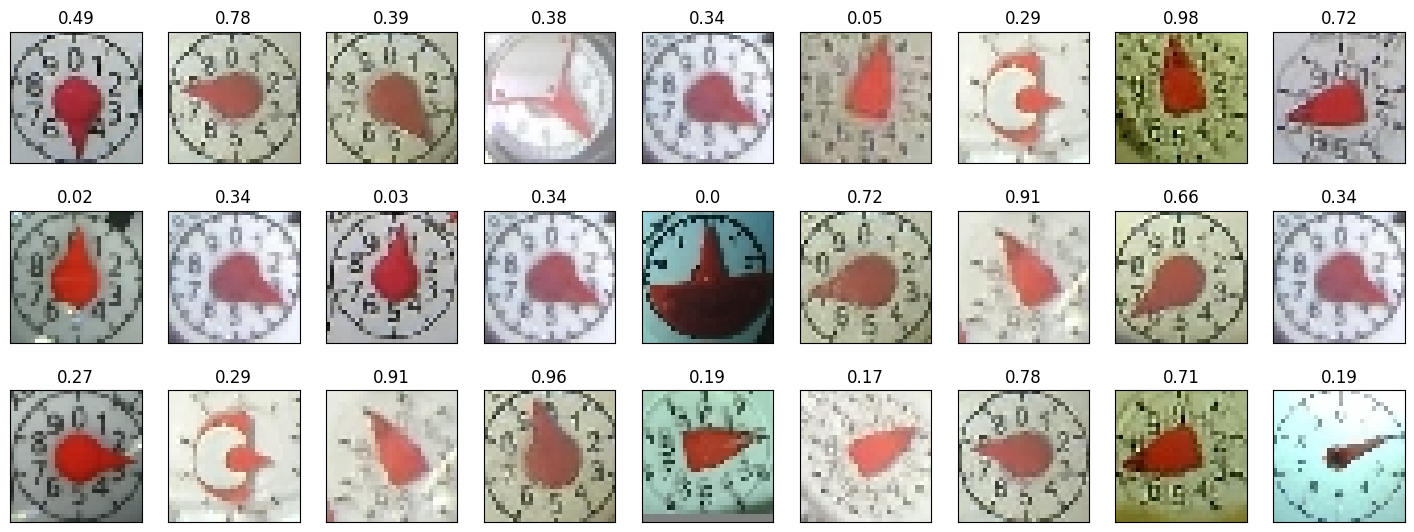

In [7]:
Batch_Size = 8
Shift_Range = 3
Brightness_Range = 0.3
Zoom_Range = 0.1

# train data
print("Train data")
#train_iterator = augmentation(x_data, y_data)
train_iterator = augmentation(x_train, y_train,
                             _Batch_Size          = Batch_Size, 
                             _width_shift_range   = Shift_Range, 
                             _height_shift_range  = Shift_Range,
                             _brightness_range    = [1-Brightness_Range, 1+Brightness_Range],
                             _zoom_range_In       = Zoom_Range,
                             _zoom_range_Out      = Zoom_Range,
                             _rotation_range      = 0,
                             _channel_shift_range = 0,
                             _shear_range         = 0,
                             _preprocessing       = True)
plot_dataset_analog(train_iterator)     

if (Training_Percentage > 0):
    # validation data
    validation_iterator = no_augmentation(x_test, y_test)
    print("  ")
    print("  ")
    print("Validation data")
    plot_dataset_analog(validation_iterator, rows=3) 


### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [ ]:
Epoch_Anz = 500

if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)


Epoch 1/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7248 - loss: 0.3553 - val_accuracy: 0.9348 - val_loss: 0.0959
Epoch 2/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7781 - loss: 0.2658 - val_accuracy: 1.0000 - val_loss: 0.0559
Epoch 3/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8469 - loss: 0.2141 - val_accuracy: 0.9130 - val_loss: 0.0702
Epoch 4/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8507 - loss: 0.2013 - val_accuracy: 0.9783 - val_loss: 0.0632
Epoch 5/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8546 - loss: 0.1858 - val_accuracy: 0.9783 - val_loss: 0.0524
Epoch 6/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8935 - loss: 0.1785 - val_accuracy: 0.9783 - val_loss: 0.0519
Epoch 7/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8602 - loss: 0.1377 - val_accuracy: 0.9565 - val_loss: 0.0577
Epoch 8/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8636 - loss: 0.1536 - 

### Overall Learing results (Step 1 & Step 2)

In [ ]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [10]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.15

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\2.8_c30648d48510d5219756c3d9176c073e.jpg 0.27999999999999997 -0.15868795 0.43868795


## Results

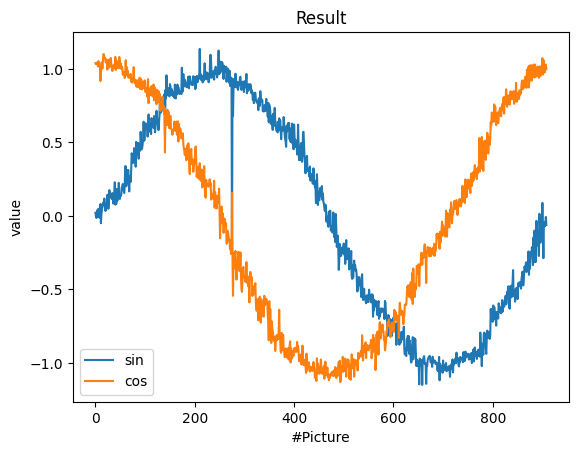

In [11]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

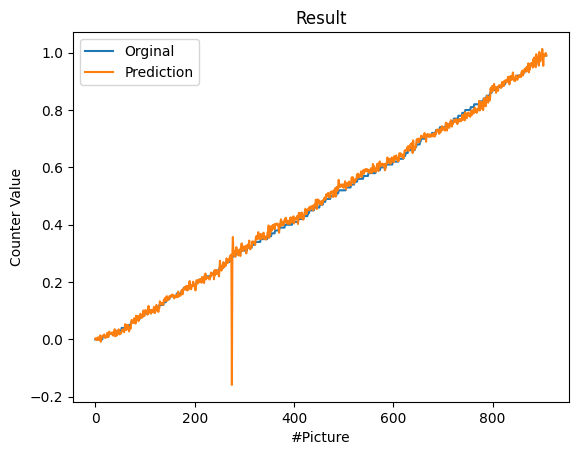

In [12]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

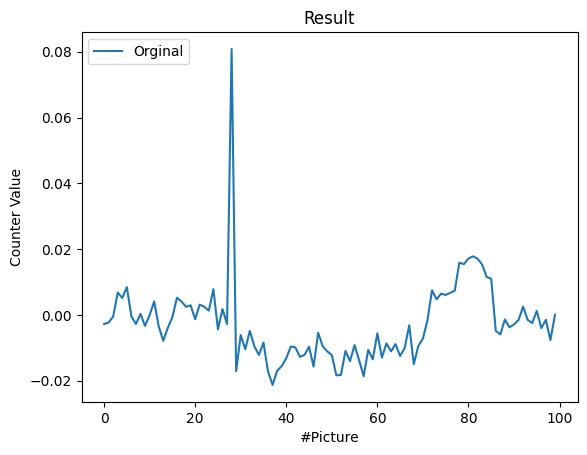

In [13]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

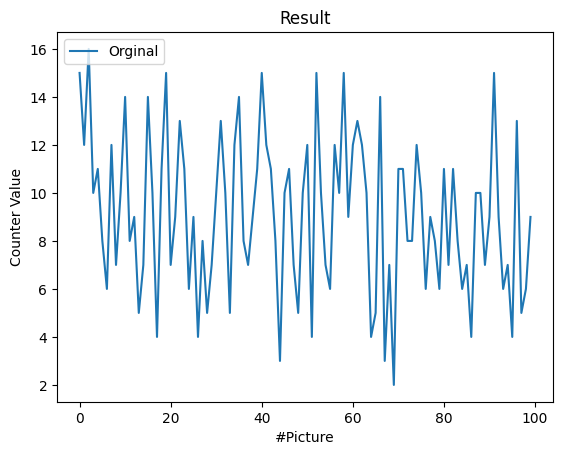

In [14]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

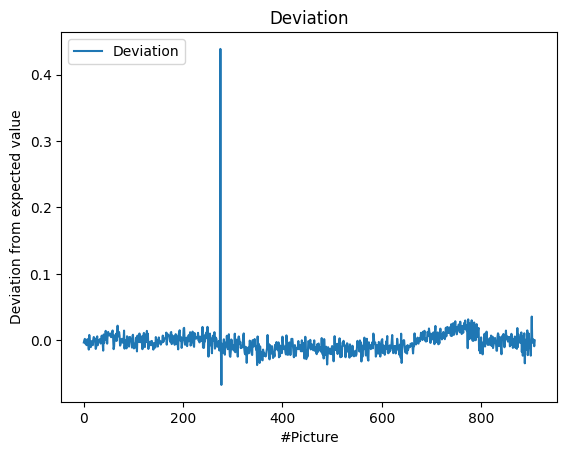

[-0.0033  0.0189 -0.0671  0.4387]


In [15]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [16]:
model.export("test", "tf_saved_model")  # replace tf.saved_model.save with this line

INFO:tensorflow:Assets written to: test\assets


INFO:tensorflow:Assets written to: test\assets


Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1532068022608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068020880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068021264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068020688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068022032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068021648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068023184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068023952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068021840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068022224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1532068023760: TensorSpec(shape=(), dtype=tf.res

In [17]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + ".tflite"

converter = tf.lite.TFLiteConverter.from_saved_model("test")
tflite_model = converter.convert()
print(FileName)
open(FileName, "wb").write(tflite_model)

ana-cont_16.00.01_s0.tflite


564576

In [28]:
print(x_data.shape)
print(x_data.shape[0])

(909, 32, 32, 3)
909


In [36]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data.shape[0]):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model("test")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
tflite_quant_model = converter.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

ana-cont_16.00.01_s0_q.tflite


151280